In [1]:
import os
import datetime

def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print('\n' + '====='*8 + '%s'%nowtime)

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from PIL import Image
import numpy as np

def my_loader(path):
  with open(path, 'rb') as f:
    with Image.open(f) as img:
      img_arr = np.array(img)
      re_img_arr = img_arr / img_arr.max() * 255
      return Image.fromarray(re_img_arr).convert('L')

In [5]:
transform_train = transforms.Compose([transforms.Grayscale(1),
                                      transforms.RandomCrop(224),
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5), (0.5))])
transform_valid = transforms.Compose([transforms.Grayscale(1),
                                      transforms.CenterCrop(224),
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5), (0.5))])

ds_train = datasets.ImageFolder("./drive/MyDrive/Dataset/GeoTIFF",
                                transform=transform_train,
                                target_transform=lambda t: torch.LongTensor([t]),
                                loader=my_loader)
ds_valid = datasets.ImageFolder("./drive/MyDrive/Dataset/Valid",
                                transform=transform_valid,
                                target_transform=lambda t: torch.LongTensor([t]),
                                loader=my_loader)
print(ds_train.class_to_idx)

{'F': 0, 'G': 1, 'H': 2, 'I': 3, 'J': 4, 'K': 5, 'L': 6, 'M': 7, 'N': 8, 'O': 9}


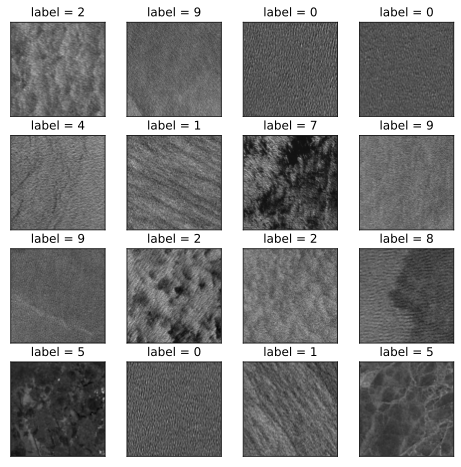

In [6]:
%matplotlib inline
%config InlineBackend.figure_format ='svg'

from matplotlib import pyplot as plt
import random

plt.figure(figsize=(8,8))
for i in range(16):
  index = random.randint(0, 7999)
  img, label = ds_train[index]
  img = img.permute(1, 2, 0)
  ax = plt.subplot(4, 4, i+1)
  ax.imshow(np.squeeze(img.numpy()), cmap='gray')
  ax.set_title('label = %d'%label.item())
  ax.set_xticks([])
  ax.set_yticks([])
plt.show()

In [7]:
# 检查dataset的数据
i ,l = ds_train[0]
i.shape

torch.Size([1, 224, 224])

In [8]:
dl_train = DataLoader(ds_train, batch_size=50, shuffle=True, num_workers=3)
dl_valid = DataLoader(ds_valid, batch_size=50, shuffle=True, num_workers=3)

In [9]:
# 检查dataloader的数据
for x,y in dl_train:
  print(x.shape, y.shape)
  break

torch.Size([50, 1, 224, 224]) torch.Size([50, 1])


In [10]:
from torchvision.models import resnet50

model = resnet50(num_classes=10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
device = torch.device("cuda")
model = model.to(device)

In [11]:
import pandas as pd
from sklearn.metrics import roc_auc_score

def my_auc(y_pred, y_true):
  pred = torch.argmax(y_pred, 1)
  correct = (pred == y_true).sum().float()
  return correct / len(y_true)


model.optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
model.loss_func = torch.nn.CrossEntropyLoss()
model.metric_func = my_auc
model.metric_name = "auc"

In [12]:
def train_step(model, features, labels):
  
  features = features.to(torch.device("cuda"))
  labels = labels.to(torch.device("cuda"))

  model.train() # 训练模式
  model.optimizer.zero_grad() # 梯度清零
  
  # 正向传播求损失
  predictions = model(features)
  loss = model.loss_func(predictions, labels.squeeze(1))
  metric = model.metric_func(nn.functional.softmax(predictions, dim=1), labels.squeeze(1))
  
  # 反向传播
  loss.backward()
  model.optimizer.step()

  return loss.item(), metric.item()

def valid_step(model, features, labels):

  features = features.to(torch.device("cuda"))
  labels = labels.to(torch.device("cuda"))
  
  model.eval() # 测试模式

  with torch.no_grad():
    predictions = model(features)
    loss = model.loss_func(predictions, labels.squeeze(1))
    metric = model.metric_func(nn.functional.softmax(predictions, dim=1), labels.squeeze(1))

  return loss.item(), metric.item()

In [13]:
# 测试训练train_step
feature_label = next(iter(dl_train))
train_step(model, feature_label[0], feature_label[1])

(2.4548609256744385, 0.14000000059604645)

In [14]:
def train_model(model, epochs, dl_train, dl_valid, log_step_freq, model_path=None):
  
  if not os.path.exists('./data'):
    os.makedirs('./data')

  if model_path is not None:
    model.load_state_dict(torch.load(model_path))
  
  # 初始化日志
  metric_name = model.metric_name
  dfhistory = pd.DataFrame(columns=['epoch', 'loss', metric_name, 
                                    'val_loss', 'val_' + metric_name])
  print('Start Training...')
  printbar()

  for epoch in range(1, epochs + 1):

    # 训练    
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1

    for step, (features, labels) in enumerate(dl_train, 1):
      
      loss, metric = train_step(model, features, labels)
      # 打印每一个batch的日志
      loss_sum += loss
      metric_sum += metric
      if step % log_step_freq == 0:
        print(("[step = %d] loss:%.3f, " + metric_name + ":%.3f") 
              % (step, loss_sum/step, metric_sum/step))
    
    # 验证
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1

    for val_step, (features, labels) in enumerate(dl_valid, 1):

      val_loss, val_metric = valid_step(model, features, labels)
      val_loss_sum += val_loss
      val_metric_sum += val_metric
    
    # 记录日志
    info = (epoch, loss_sum/step, metric_sum/step,
            val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch - 1] = info

    print(("\n EPOCH=%d, loss=%.3f, " + metric_name + 
          "=%.3f, val_loss=%.3f, " + "val_" + metric_name + "=%.3f") % info)
    printbar()

    # 保存模型参数
    if epoch % 5 == 0:
      print('====='*8 + 'EPOCH=%d save mode'%epoch)
      torch.save(model.state_dict(), './data/epoch' + str(epoch) + '_model_parameter.pkl')
  
  print('Finish Training ...')
  return dfhistory

In [15]:
dfhistory = train_model(model, 100, dl_train, dl_valid, log_step_freq=50)

Start Training...

========================================2021-02-21 14:04:05
[step = 50] loss:2.692, auc:0.234
[step = 100] loss:2.437, auc:0.296
[step = 150] loss:2.199, auc:0.329

 EPOCH=1, loss=2.157, auc=0.334, val_loss=1.906, val_auc=0.343

========================================2021-02-21 14:21:26
[step = 50] loss:1.614, auc:0.430
[step = 100] loss:1.569, auc:0.442
[step = 150] loss:1.555, auc:0.456

 EPOCH=2, loss=1.549, auc=0.456, val_loss=1.778, val_auc=0.492

========================================2021-02-21 14:23:28
[step = 50] loss:1.354, auc:0.520
[step = 100] loss:1.346, auc:0.521
[step = 150] loss:1.333, auc:0.532

 EPOCH=3, loss=1.326, auc=0.534, val_loss=1.759, val_auc=0.470

========================================2021-02-21 14:25:19
[step = 50] loss:1.226, auc:0.580
[step = 100] loss:1.203, auc:0.585
[step = 150] loss:1.184, auc:0.586

 EPOCH=4, loss=1.179, auc=0.585, val_loss=1.745, val_auc=0.617

========================================2021-02-21 14:26:52
[step

In [16]:
dfhistory.to_csv('./data/dfhistory.csv')

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
  train_metrics = dfhistory[metric]
  val_metrics = dfhistory['val_' + metric]
  epochs = range(1, len(train_metrics) + 1)
  plt.plot(epochs, train_metrics, 'bo--')
  plt.plot(epochs, val_metrics, 'ro-')
  plt.title('Training and validation ' + metric)
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend(['train_' + metric, 'val_' + metric])
  plt.savefig(metric + '.png')
  plt.show()

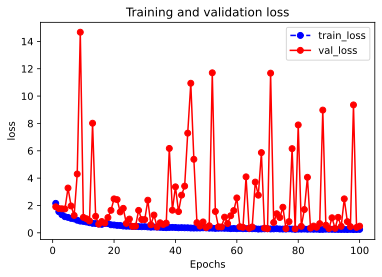

In [18]:
plot_metric(dfhistory, 'loss')

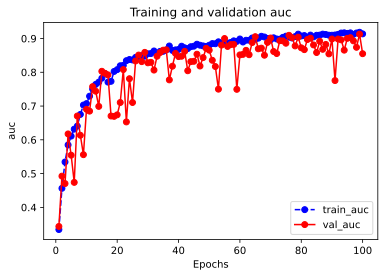

In [19]:
plot_metric(dfhistory, 'auc')

In [ ]:
from google.colab import files
import os, tarfile

def make_targz_one_by_one(output_filename, source_dir):
  tar = tarfile.open(output_filename,"w")
  for root, dir_name, files_list in os.walk(source_dir):
    for file in files_list:
      pathfile = os.path.join(root, file)
      tar.add(pathfile)
  tar.close()
 
  files.download(output_filename)

In [ ]:
make_targz_one_by_one('data_resnet34', './data')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
!cp -r ./data ./drive/MyDrive